In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import polars as pl
from pathlib import Path
import torch

from scipy import signal
import ssm
import pywt 
from scipy.ndimage import gaussian_filter1d
from scipy.signal import butter, filtfilt
from scipy.signal import savgol_filter
import pandas as pd
from dynamax.hidden_markov_model import LinearAutoregressiveHMM,GaussianHMM 
from dynamax.utils.plotting import gradient_cmap
from dynamax.utils.utils import random_rotation
from transphorm.preprocessors.loaders import AADataLoader
from transphorm.analyzers import ARHMMAnalyzer


In [3]:
path = "/Users/mds8301/Desktop/temp/dopamine_full_timeseries_array.pt"

data = AADataLoader(path, down_sample=False)
data.load_data()
data.prepare_data(low_pass=True, down_sample=True)

data.x.shape

(88, 15035)

In [55]:
len_test = data.test[0].shape[0]

train_lst = [x[:len_test] for x in data.train]



  0%|          | 0/5 [00:00<?, ?it/s]

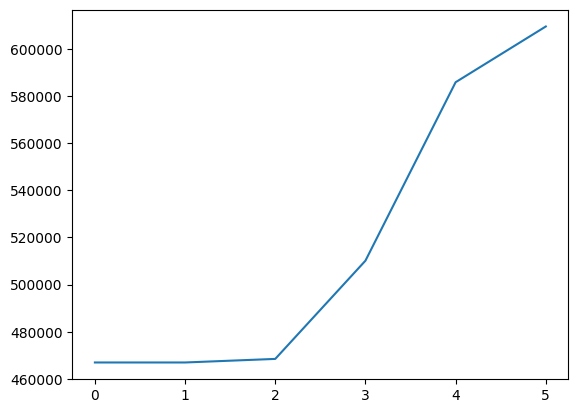

In [56]:
model = ssm.HMM(K = 3, D = 1, M = 1, observations = 'ar')
lls = model.fit(data.train, method='em', num_iters=5)
plt.plot(lls)

In [69]:
print('As', model.observations._As)
print('Sigmas', model.observations.Sigmas)




As [[[0.97030013]]

 [[0.98117341]]

 [[0.95529516]]]
Sigmas [[[0.05589238]]

 [[0.00770605]]

 [[0.01903613]]]


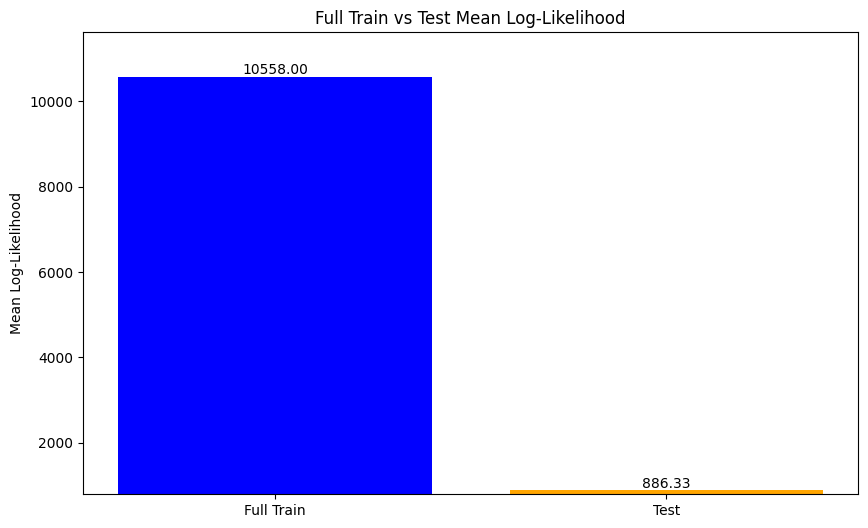

In [46]:
len_test = data.test[0].shape[0]

full_train_log_likelihood = model.log_likelihood(data.train)
test_log_likelihood = model.log_likelihood(data.test)
# Create a bar plot for train and test log-likelihood
# Calculate mean log-likelihoods for full train, train, and test data
mean_full_train_log_likelihood = full_train_log_likelihood / len(data.train)
mean_test_log_likelihood = test_log_likelihood / len(data.test)

# Create a bar plot for full train, train, and test log-likelihood
# Create a bar plot for full train and test log-likelihood
plt.figure(figsize=(10, 6))
log_likelihoods = [mean_full_train_log_likelihood, mean_test_log_likelihood]
labels = ['Full Train', 'Test']
colors = ['blue', 'orange']

plt.bar(labels, log_likelihoods, color=colors)
plt.title('Full Train vs Test Mean Log-Likelihood')
plt.ylabel('Mean Log-Likelihood')
plt.ylim(min(log_likelihoods) - abs(min(log_likelihoods)*0.1), max(log_likelihoods) + abs(max(log_likelihoods)*0.1))

for i, v in enumerate(log_likelihoods):
    plt.text(i, v, f'{v:.2f}', ha='center', va='bottom')

plt.show()




In [43]:
mean_full_train_log_likelihood
np.exp(-mean_full_train_log_likelihood)

0.0

In [41]:
def perplexity(normalized_ll):
    return np.exp(-normalized_ll)

train_perplexity = perplexity(mean_full_train_log_likelihood)
test_perplexity = perplexity(mean_test_log_likelihood)
test_perplexity
# Create a bar plot for train and test perplexity
# plt.figure(figsize=(10, 6))
# perplexities = [train_perplexity, test_perplexity]
# labels = ['Train', 'Test']
# colors = ['blue', 'orange']

# plt.bar(labels, perplexities, color=colors)
# plt.title('Train vs Test Perplexity')
# plt.ylabel('Perplexity')
# plt.ylim(0, max(perplexities) + max(perplexities)*0.1)

# for i, v in enumerate(perplexities):
#     plt.text(i, v, f'{v:.2f}', ha='center', va='bottom')

# plt.show()


# Calculate mean log probabilities for train and test data


0.0

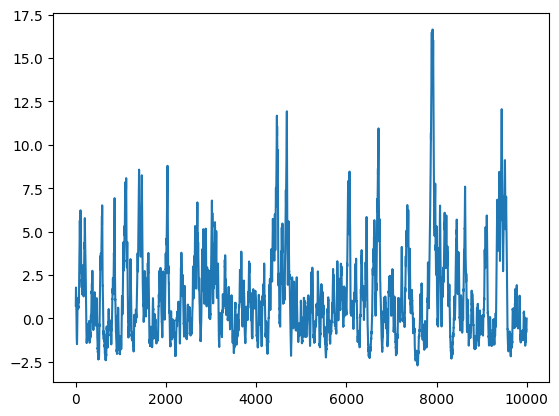

In [39]:
# sample from model
samples = model.sample(10000)
# plt.plot(samples)
plt.plot(samples[1])

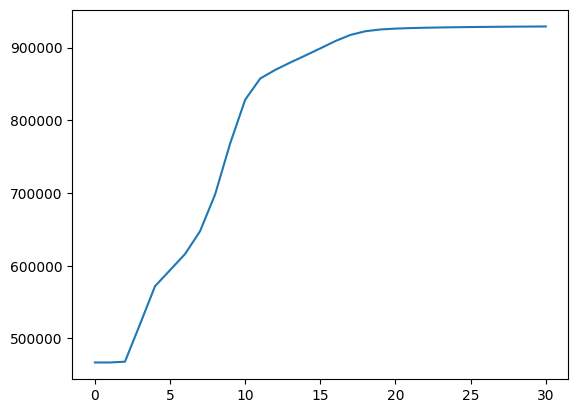

In [47]:
plt.plot(lls)

In [ ]:
padded_state_0_segments = get_segments(state_0_motif)
padded_state_1_segments = get_segments(state_1_motif)
padded_state_2_segments = get_segments(state_2_motif)
# padded_state_3_segments = get_segments(state_3_motif)
# padded_state_4_segments = get_segments(state_4_motif)
# padded_state_5_segments = get_segments(state_5_motif)
# padded_state_6_segments = get_segments(state_6_motif)
# padded_state_7_segments = get_segments(state_7_motif)


fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(12, 6), sharex=False)

plot_segments(padded_state_0_segments, ax[0,0], color='red')
plot_segments(padded_state_1_segments, ax[0,1], color='blue')
plot_segments(padded_state_2_segments, ax[0,2], color='green')
# plot_segments(padded_state_3_segments, ax[0,3], color='purple')
# plot_segments(padded_state_4_segments, ax[1,0], color='orange')
# plot_segments(padded_state_5_segments, ax[1,1], color='pink')
# plot_segments(padded_state_6_segments, ax[1,2], color='brown')
# plot_segments(padded_state_7_segments, ax[1,3], color='gray')

# plot_segments(padded_state_3_segments, ax[1,1], color='purple')
# plot_segments(padded_state_4_segments, ax[4])
# plot_segments(padded_state_5_segments, ax[5])

plt.tight_layout()